In [1]:
import pandas as pd
import numpy as np
import scipy
from statsmodels.stats.weightstats import *
from  scipy.stats import chi2_contingency

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [4]:
data_0 = data[data.default==0]
data_1 = data[data.default==1]

## 1(a) гипотеза о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

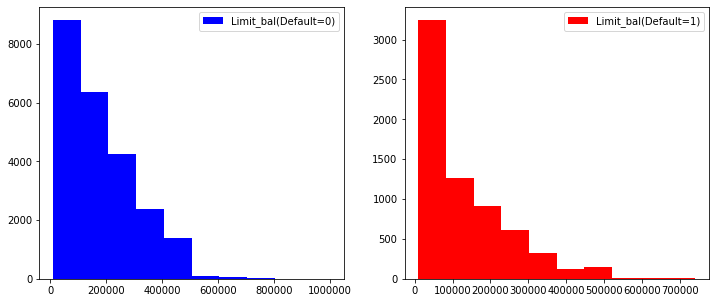

In [5]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data_0.LIMIT_BAL, color='b', label='Limit_bal(Default=0)')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data_1.LIMIT_BAL, color='r', label='Limit_bal(Default=1)')
pylab.legend()

pylab.show()

#### Видно что графики имеют схожие распределения. Графики сильно скошены влево.  

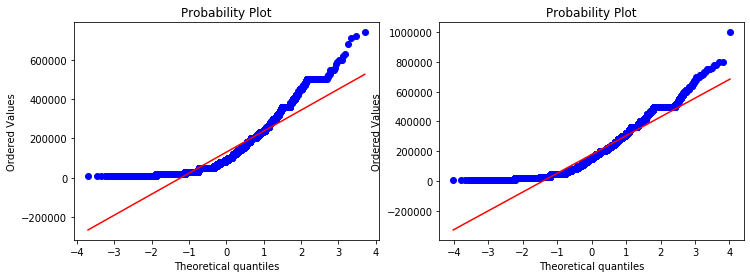

In [6]:
pylab.figure(figsize=(12,4))
pylab.subplot(1,2,1)
stats.probplot(data_1.LIMIT_BAL, dist="norm", plot=pylab)
pylab.subplot(1,2,2)
stats.probplot(data_0.LIMIT_BAL, dist="norm", plot=pylab)
pylab.show()

Критерий Шапиро-Уилка:

 $H_0\colon$ размеры кредитных лимитов распредлены нормально
 
 $H_1\colon$ не нормально.

In [7]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data_0.LIMIT_BAL))

Shapiro-Wilk normality test, W-statistic: 0.919726, p-value: 0.000000


D:\Programs\anaconda3\envs\python37\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [8]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data_1.LIMIT_BAL))

Shapiro-Wilk normality test, W-statistic: 0.854983, p-value: 0.000000


т.к. гипотеза о нормальности отвергается и на Q-Q графиках видно, что распределение не близко к нормальному мы не можем пользоваться критерием Стьюдента для проверки гипотезы о равенстве медиан.
Воспользуемся построением интервальной оценки с помощью бутстрапа.

In [9]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [10]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

 $H_0\colon$ разница медиан размеров кредитного лимита равна нулю.
 
 $H_1\colon$ не равна нулю.

In [13]:
np.random.seed(0)

default_0_median_scores = [np.median(s) for s in get_bootstrap_samples(data_0.LIMIT_BAL.values, 1000)]
default_1_median_scores = [np.median(s) for s in get_bootstrap_samples(data_1.LIMIT_BAL.values, 1000)]

delta_median_scores = [x[0] - x[1] for x in zip(default_0_median_scores, default_1_median_scores)]

print("95% confidence interval:",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval: [60000. 70000.]


Мы получили 95% интервал для разницы медиан [60000, 70000]. Так как интервал не содержит 0, то гипотеза $H_0$ отвергается. Это означает, что возможно кредитный лимит влияет на то, сможет ли человек вернуть кредит.

## 1(b) гипотеза о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Из графиков распределения выборок делаем предположение о том что они распределены по одному закону и воспользуемся ранговым критерием Манна-Уитни. Можем его использовать так как имеем 2 независимые выборки

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [14]:
stats.mannwhitneyu(data_0.LIMIT_BAL.values, data_1.LIMIT_BAL.values)

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

Получившееся p_value близко к нулю, а значит $H_0$ отвергается. Практическая значимость: среднее значение для кредитных лимитов отличается в группах вернувших долг и не вернувших долг

## 2. Пол (SEX): Гипотеза о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается. 

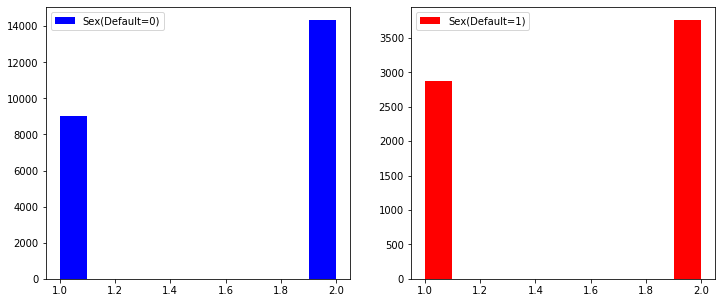

In [15]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data_0.SEX, color='b', label='Sex(Default=0)')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data_1.SEX, color='r', label='Sex(Default=1)')
pylab.legend()

pylab.show()

На графиках мы видим, что пропорция мужчин для выборки где кредит был возвращен меньше, чем для выборки где кредит не был возвращен

Воспользуемся Z-критерием для разности долей. Можем это сделать потому что выборки бинарны и независимы.

$H_0\colon$ гендерный состав  группы людей вернувших и не вернувших кредит не отличается

$H_1\colon$ гендерный состав  группы людей вернувших и не вернувших кредит отличается

In [16]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [17]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [18]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [19]:
# rename labels
# 0 - man
# 1 - woman

sex_def_0 =  data_0.SEX - 1
sex_def_1 =  data_1.SEX - 1

In [20]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(sex_def_0, sex_def_1)))

p-value: 0.000000


In [21]:
proportions_diff_confint_ind(sex_def_0, sex_def_1)

(0.03363493274962867, 0.060548077974896725)

Нулевая гипотеза отвергается. 95% Доверительный интервал разности долей составляет от 3% до 6% и не содержит 0. Это позволяет выдвинуть предположение, что гендерный составдля групп возврата\не возврата кредита различается

## 3.  Гипотеза о том, что образование не влияет на то, вернет ли человек долг.

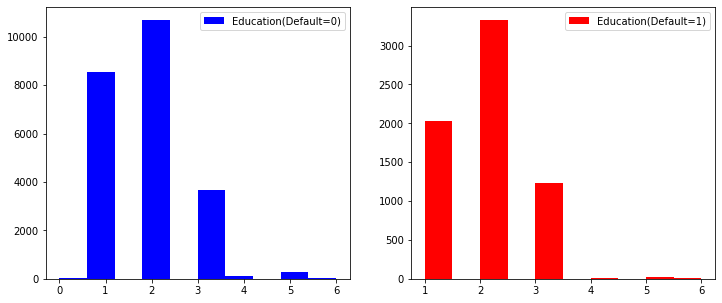

In [22]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data_0.EDUCATION, color='b', label='Education(Default=0)')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data_1.EDUCATION, color='r', label='Education(Default=1)')
pylab.legend()

pylab.show()

Условия применимости критерия Хи2 выполняются
n > 40
число ячеек, где количество наблюдений меньше пяти составляет менее 20%

$H_0\colon$ взаимосвязь между образованием и возвратом долга отсутствует

$H_1\colon H_0$ не верна

In [23]:
data_0.EDUCATION.value_counts()

2    10700
1     8549
3     3680
5      262
4      116
6       43
0       14
Name: EDUCATION, dtype: int64

In [24]:
data_1.EDUCATION.value_counts()

2    3330
1    2036
3    1237
5      18
6       8
4       7
Name: EDUCATION, dtype: int64

In [25]:
kf_data = np.array([[14, 8549, 10700, 3680, 116, 262, 43], [0, 2036, 3330, 1237, 7, 18, 8]])
kf = chi2_contingency(kf_data)

In [26]:
kf

(163.21655786997073,
 1.2332626245415605e-32,
 6,
 array([[1.0903200e+01, 8.2435980e+03, 1.0926564e+04, 3.8293596e+03,
         9.5792400e+01, 2.1806400e+02, 3.9718800e+01],
        [3.0968000e+00, 2.3414020e+03, 3.1034360e+03, 1.0876404e+03,
         2.7207600e+01, 6.1936000e+01, 1.1281200e+01]]))

p < 0.05 а значит $H_0$ отвергается в пользу $H_1$

Таблица разности

In [49]:
(kf_data - kf[3])

array([[   3.0968,  305.402 , -226.564 , -149.3596,   20.2076,   43.936 ,
           3.2812],
       [  -3.0968, -305.402 ,  226.564 ,  149.3596,  -20.2076,  -43.936 ,
          -3.2812]])

Модификация таблицы разности:

In [52]:
(kf_data / kf[3])

array([[1.28402671, 1.03704717, 0.97926484, 0.96099619, 1.21095202,
        1.20148213, 1.08261075],
       [0.        , 0.86956447, 1.07300424, 1.13732443, 0.25728105,
        0.29062258, 0.70914442]])

Мы видим что для тех, кто не отдал долг значение 4 (начальное образование) является самым маленькое (-75%)
Для тех, кто отдал долг значение 0 (доктор) самое большое (+28%)

Таким образом докторская степень является наилучшим индикатором, что долг будет отдан, а начальное образование наилучшим индикатором, что долг не будет отдан

In [53]:
kf_data

array([[   14,  8549, 10700,  3680,   116,   262,    43],
       [    0,  2036,  3330,  1237,     7,    18,     8]])

## 4.  Семейное положение (MARRIAGE)

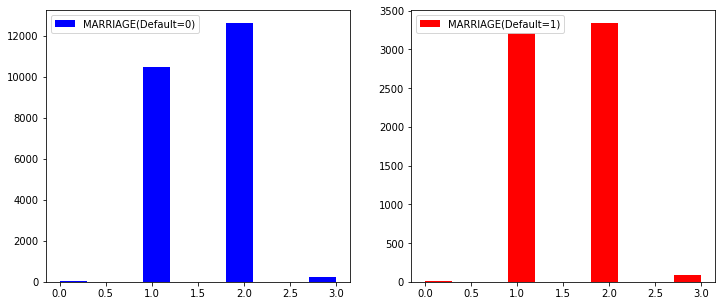

In [27]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data_0.MARRIAGE, color='b', label='MARRIAGE(Default=0)')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data_1.MARRIAGE, color='r', label='MARRIAGE(Default=1)')
pylab.legend()

pylab.show()

Условия применимости критерия Хи2 выполняются
n > 40
число ячеек, где количество наблюдений меньше пяти составляет менее 20%

$H_0\colon$ взаимосвязь между семейным положением и возвратом долга отсутствует

$H_1\colon H_0$ не верна 

In [28]:
data_0.MARRIAGE.value_counts()

2    12623
1    10453
3      239
0       49
Name: MARRIAGE, dtype: int64

In [29]:
data_1.MARRIAGE.value_counts()

2    3341
1    3206
3      84
0       5
Name: MARRIAGE, dtype: int64

In [30]:
marriage_default = np.array([[49, 10453, 12623, 239], [5, 3206, 3341, 84]])

In [44]:
stats.chi2_contingency(marriage_default, correction=False)

(35.66239583433609,
 8.825862457577375e-08,
 3,
 array([[4.20552000e+01, 1.06376292e+04, 1.24327632e+04, 2.51552400e+02],
        [1.19448000e+01, 3.02137080e+03, 3.53123680e+03, 7.14476000e+01]]))

p-value < 0.05 а значит гипотеза об отсутствии взаимосвязи между семейным положением и переменной deafault отвергается

Вычислим меру связи с помощью кореляции Крамера

In [31]:
X2 = stats.chi2_contingency(marriage_default, correction=False)[0]
n = np.sum(marriage_default)
minDim = min(marriage_default.shape)-1
V = np.sqrt((X2/n) / minDim)

корреляция Крамера 0.034478203662766466. 

Хоть гипотеза об отсутствии взаимосвязи была отвергнута судя по корреляции Крамера можем сказать что взаимосвязь слабая, так как корреляция Крамера близка к нулю 

## 5a) гипотеза о равенстве медианных значений возрастов

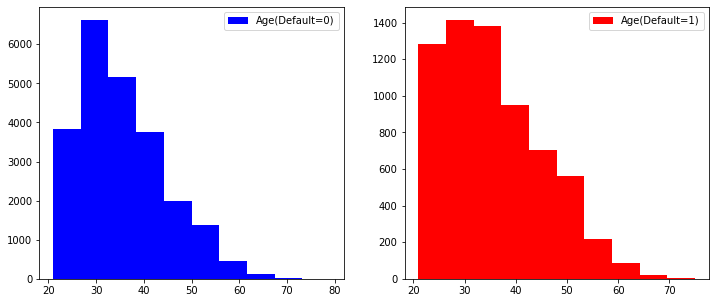

In [35]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data_0.AGE, color='b', label='Age(Default=0)')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data_1.AGE, color='r', label='Age(Default=1)')
pylab.legend()

pylab.show()

In [37]:
np.random.seed(0)

age_default_0_median_scores = [np.median(s) for s in get_bootstrap_samples(data_0.AGE.values, 1000)]
age_default_1_median_scores = [np.median(s) for s in get_bootstrap_samples(data_1.AGE.values, 1000)]

age_delta_median_scores = [x[0] - x[1] for x in zip(age_default_0_median_scores, age_default_1_median_scores)]

print("95% confidence interval:",  stat_intervals(age_delta_median_scores, 0.05))

95% confidence interval: [-1.  0.]


Нет оснований отвергать гипотезу $H_0$ т.к. интервальная оценка содержит 0

## 5(b) гипотеза о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Используем критерий Манна-Уитни. Можем это сделать так как у нас две независимые выборки.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [38]:
stats.mannwhitneyu(data_0.AGE.values, data_1.AGE.values)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.3725035434898616)

т.к. p > 0.05, то нет оснований отвергать гипотезу $H_0$

Практическая значимость: нельзя сказать, что медианы возрастов для вернувших\не вернувших долг отличаются